# **Image Captioning with Visual Attention Model**


---


The aim of the project is to implement a model that translates an image into its relevant description. A CNN-RNN architecture is used for the implementation. The model architecture uses a CNN encoder to extract the features from the image followed by attention based networks and GRU(RNN based decoder) to decode the features into textual context. The architecture is similar to the one used in  *K. Xu, J. Ba, R. Kiros, A. Courville, R. Salakhutdinov,
R. Zemel, and Y. Bengio. **Show, attend and tell: Neural image caption generation with visual attention**. arXiv preprint arXiv:1502.03044, 2015*


The dataset used here is a subset of the MS-COCO dataset from it's first release in 2014. 30,000 image caption pairs are used for this purpose. A pre-trained Inception V3 architecture model was used to extract the image features and further passing it on to the decoder. 

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

    100% |████████████████████████████████| 332.1MB 50kB/s 
    100% |████████████████████████████████| 61kB 29.4MB/s 
    100% |████████████████████████████████| 419kB 11.5MB/s 
    100% |████████████████████████████████| 3.0MB 8.3MB/s 


## Download and prepare the MS-COCO dataset

The MS-COCO dataset is used to train our model. The dataset from its first release in 2014 contains  82,783 training, 40,504 validation, and 40,775 testing images (approximately 1/2
train, 1/4 validation, and 1/4 test images). There are nearly 270k segmented people and a total of 886k segmented object instances in the 2014 train+val data alone and 80 categories. 

This dataset with over 82,000 images has been annotated with at least 5 different captions. 

The code below will download and extract the dataset automatically from its source.


In [3]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

13510574080/13510573713 [==============================] - 220s 0us/step


## Limiting the size of the dataset for faster training

As mentioned earlier, a subset of 30,000 image-caption pairs from the total will be used to trained the model and evaluated against the BLEU metric. 

In [0]:
# read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# storing the captions and the image name in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# selecting the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [5]:
len(train_captions), len(all_captions)

(30000, 414113)

## Extracting the image features using InceptionV3

The InceptionV3 architecture (pretrained on Imagenet) is used to classify each image. We will extract features from the last convolutional layer.

![Inception V3 Model](https://cdn-images-1.medium.com/max/1000/1*gqKM5V-uo2sMFFPDS84yJw.png)

The images will be resized to 299x299 and the pixels will be normalized to fall in the range (-1,1) in order to match the format of images used in inception V3. 


In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

The fully connected layer will removed from the model to extract the image features. Each image is forwarded through the network and the vector that's obtained will be stored in a dictionary. Since we are attention networks further, we remove the dense layers from the CNN model(Inception V3). The shape of the output layer is 8x8x2048.

Once all the images are passed through the network, the dictionary will be dumped into a pickle file and saved to the disk.

In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3

The preprocessed image output with Inception V3 will be cached to the disk. Although Caching the output to the RAM is faster, it is memory intensive requiring 8x8x2048 floats per image. 

In [0]:
# getting the unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions



* In the first step, the captions were tokenized to give a vocabulary of all the unique words.

* The vocabulary size is limited to 5000 words and the other words in the vocabulary are replaced by the "UNK" token which denotes unknown.
  
* Create a word --> index mapping and vice-versa.
  
* All sequences are padded to the be same length as the longest one.

In [0]:
# This will find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# The steps above is a general process of dealing with text processing

# choosing the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
# padding each vector to the max_length of the captions
# if the max_length parameter is not provided, pad_sequences calculates that automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
# calculating the max_length
# used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [0]:
# Create training and validation sets using 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [16]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.



In [0]:
# feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# shape of the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64

In [0]:
# loading the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# using map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

W0421 21:04:28.592895 140616727512960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py:476: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


## Model

The model architecture is inspired by 

The decoder is identical to the sequence to sequence architecture.

![Seq2Seq](https://cdn-images-1.medium.com/max/1000/1*3lj8AGqfwEE5KCTJ-dXTvg.png)

* We extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* We squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder(which consists of a single Fully connected layer).
* The RNN(here GRU) attends over the image to predict the next word.

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training

* Extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [29]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0871
Epoch 1 Batch 100 Loss 1.1662
Epoch 1 Batch 200 Loss 1.0605
Epoch 1 Batch 300 Loss 0.8617
Epoch 1 Loss 1.067567
Time taken for 1 epoch 181.1247217655182 sec

Epoch 2 Batch 0 Loss 0.8576
Epoch 2 Batch 100 Loss 0.8593
Epoch 2 Batch 200 Loss 0.8358
Epoch 2 Batch 300 Loss 0.7377
Epoch 2 Loss 0.805662
Time taken for 1 epoch 117.69809484481812 sec

Epoch 3 Batch 0 Loss 0.7467
Epoch 3 Batch 100 Loss 0.7876
Epoch 3 Batch 200 Loss 0.7707
Epoch 3 Batch 300 Loss 0.6775
Epoch 3 Loss 0.732807
Time taken for 1 epoch 117.74906802177429 sec

Epoch 4 Batch 0 Loss 0.6984
Epoch 4 Batch 100 Loss 0.7391
Epoch 4 Batch 200 Loss 0.7250
Epoch 4 Batch 300 Loss 0.6366
Epoch 4 Loss 0.687871
Time taken for 1 epoch 117.85534167289734 sec

Epoch 5 Batch 0 Loss 0.6561
Epoch 5 Batch 100 Loss 0.7073
Epoch 5 Batch 200 Loss 0.6934
Epoch 5 Batch 300 Loss 0.6036
Epoch 5 Loss 0.653685
Time taken for 1 epoch 121.05649256706238 sec

Epoch 6 Batch 0 Loss 0.6358
Epoch 6 Batch 100 Loss 0.6759
Epoch 6 

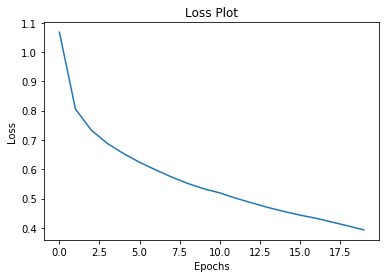

In [30]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a group of red buses driving down a street next to a person crossing it <end>
Prediction Caption: a red double decker bus driving down a road <end>


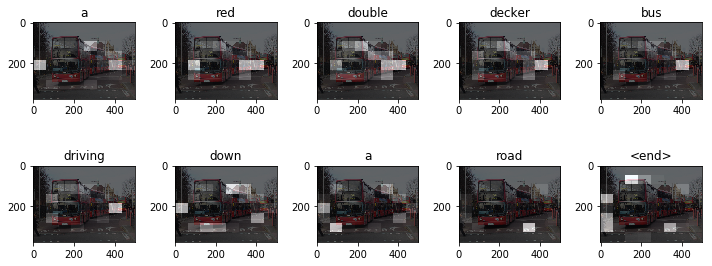

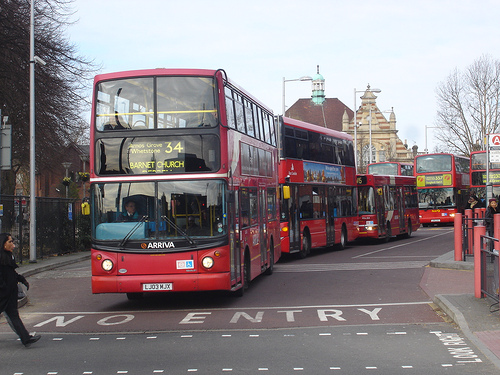

In [97]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])


#Evaluating the BLEU-n score



In [98]:
# captions on the validation set
import numpy as np
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

# opening the image
reference = real_caption
candidate = result
cc = SmoothingFunction()
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(0.30,0, 0, 0),smoothing_function=cc.method3))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0,0.40,0,0),smoothing_function=cc.method3))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0.5, 0),smoothing_function=cc.method3))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 0.5),smoothing_function=cc.method3))

Individual 1-gram: 0.501187
Individual 2-gram: 0.314696
Individual 3-gram: 0.176777
Individual 4-gram: 0.133631
